# Generating supratidal extent confidence layer

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()

sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity


## user inputs: tile, time and export geotiffs?


In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

### using GA coastal tiles geojson


In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

### append HAT and HAT + storm surge
- TODO: pretty clunky at the moment

In [4]:
# HAT_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/HAT_CSIRO/HAT_MLP_Regression.gpkg'
HAT_path = '../data/HAT_MLP_Regression.gpkg'
HAT_gpd = gpd.read_file(HAT_path)
HAT_gpd_EPSG4326 = HAT_gpd.to_crs('EPSG:4326')

HAT_SS_path = '../data/STF_SS_ElevationClasses.geojson'
HAT_SS_gpd = gpd.read_file(HAT_SS_path)

In [5]:
# HAT
# Using sjoin to add mainland_grid to HAT values 
mainland_grid_HAT = gpd.sjoin(HAT_gpd_EPSG4326, mainland_grid, predicate='within')
# get maximum HAT value within coastal tile
max_values_HAT = mainland_grid_HAT.groupby('index_right')['HAT'].max()
# # append to new column
mainland_grid['HAT'] = max_values_HAT.astype(float)

# checking NaN values and replacing them with values from adjacent tiles ---NaN values in ID 52 (51) and 235 (234) will be replaced by nearby ID 53 (4.213) and ID 243 (1.904), respectively
# TODO: need to make this automated and not hardcoded as it is problematic with any changes in indexing #
mainland_grid.loc[51,'HAT'] = 4.213
mainland_grid.loc[234,'HAT'] = 1.904

/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
# HAT_SS
# Spatial join to find which geometries in gdf1 are within any polygon of gdf2
joined = gpd.sjoin(mainland_grid, HAT_SS_gpd, how = 'left', predicate='intersects')

# Dissolve duplicates the result based on the index
dissolved_joined = joined.dissolve(by=joined.index, aggfunc='first')

# Reset the index of the dissolved GeoDataFrame
dissolved_joined = dissolved_joined.reset_index(drop=True)

# Reset the index of mainland_grid to avoid duplicate index labels
mainland_grid = mainland_grid.reset_index(drop=True)

# add SS value
mainland_grid['SS'] = dissolved_joined['SSElev']
# generate new col for HAT+SS
mainland_grid['HAT_SS'] = mainland_grid['HAT'] + mainland_grid['SS']

### select the tile of interest (click on map above and find value for `id` and manually select using `loc` below)

In [7]:
gdf = mainland_grid.loc[mainland_grid['id'] == 27]
gdf.explore()

In [8]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [9]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 9/1


### load strm, wofs, item, mangroves, MrVBF
- maybe also do if else statement for other layers like mangrove?
- 8.3.24: MrVBF removed for now as values of 0 (suggesting high slope/erosional) are problematic for areas of east coast where srtm is wrong due to very dense casuarina canopies

In [10]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h

# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in water from wofs
wofs = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query)
# get water class
water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# # Load in MrVBF
# geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/MrVBF_1_arc-second_resolution/mrvbf_int.tif'
# # load in geotiff again but with identical extent from srtm
# MrVBF = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
# MrVBF.attrs['crs'] = 'EPSG:3577'

### create supratidal extent mask

In [11]:
## wrangle binary maps and create supratidal mask

# SRTM
# greater than 0m AHD and less than 10m AHD == True
### some areas in NT are below 0 AHD and need to be included in potential supratidal extent.
### may cause some issues - Raf to check
AHD_min = -6
AHD_max = 10

lessthan10m_AHD = srtm <= AHD_max
greaterthan0m_AHD = srtm >= AHD_min
AHD_threshold_srtm = lessthan10m_AHD & greaterthan0m_AHD

# # MrVBF (mask class 0 30% Erosional, class 1 16% Small hillside deposit, class 2 8% Narrow valley floor)
# MrVBF_mask = ((MrVBF >= 2) & (MrVBF <= 9))

# not water
not_water = (1 - mangrove)
not_water = not_water == 1

# not mangrove == True
not_mangrove = (1 - water)
not_mangrove = not_mangrove == 1

# not exposed intertidal == True
# not_intertidal = item == 9
intertidal = (item >= 2) & (item <= 8)
not_intertidal = (1 - intertidal)

# remove time dims
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_water = not_water.squeeze('time')
not_mangrove = not_mangrove.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

In [12]:
# combine masks
# where its not mangrove or exposed intertidal, but is within 0-10m AHD and has low relief (MrVBF)
# supratidal = xr.where((AHD_threshold_srtm == True) & (MrVBF_mask == True) & (not_mangrove == True) & (not_intertidal == True), 1, 0).astype('int8')
supratidal = xr.where((AHD_threshold_srtm == True) & (not_water == True) & (not_mangrove == True) & (not_intertidal == True), 1, 0).astype('int8')

# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
supratidal_mask = supratidal.where(mask)

In [13]:
# get elevation values for supratidal_mask
supratidal_elev = srtm * supratidal_mask
supratidal_elev = xr.where(supratidal_elev == 0, np.nan, supratidal_elev.values)

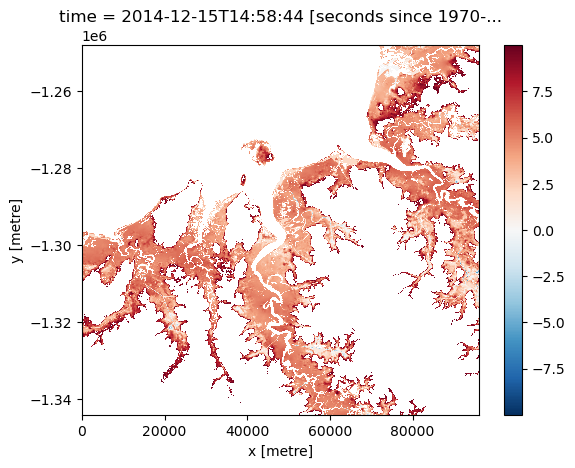

In [14]:
supratidal_elev.plot()

### generate elevation probability product
- values of 1 for <= HAT
- values normalised > HAT and <= HAT_SS
- values normalised > HAT_SS and <= 10m AHD

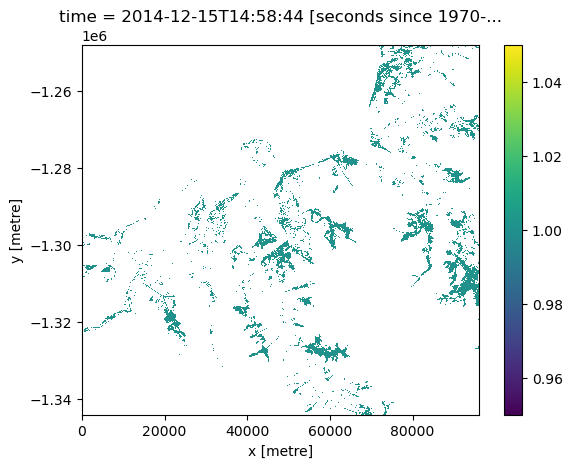

In [15]:
# HAT
HAT = xr.where(supratidal_elev <= gdf.HAT.values[0], 1, np.nan)
HAT.plot()

In [16]:
# HAT + storm
HAT_storm = xr.where((supratidal_elev > gdf.HAT.values[0]) & (supratidal_elev <= gdf.HAT_SS.values[0]), supratidal_elev.values, np.nan)

In [17]:
# normalise between HAT and HAT_SS

# Find the minimum and maximum values in the data array
min_value = gdf.HAT.values[0]
max_value = gdf.HAT_SS.values[0]
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_norm = (HAT_storm - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_norm_05_1 = (((1 - HAT_storm_norm)/2) + 0.5)

Minimum Value: 3.399249315261841
Maximum Value: 6.899249315261841


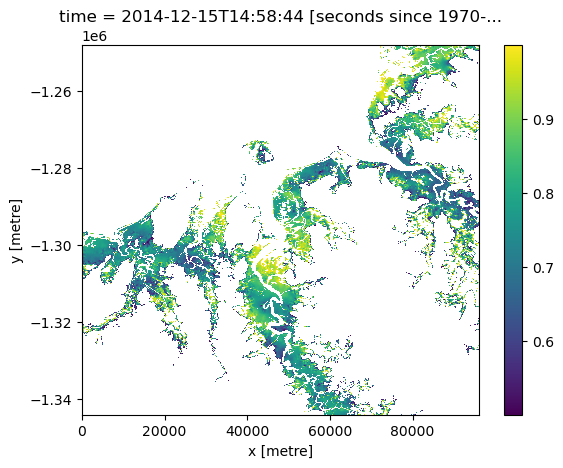

In [18]:
HAT_storm_norm_05_1.plot()

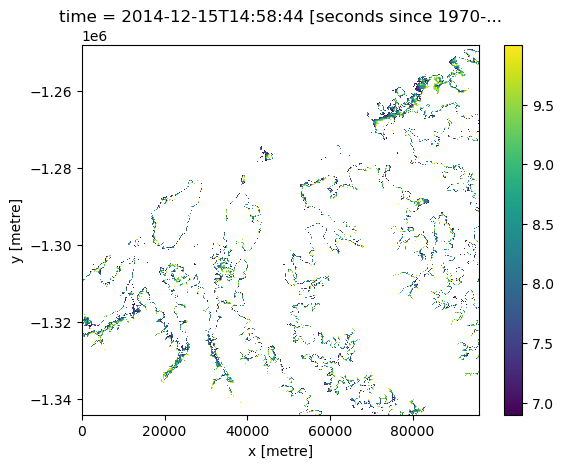

In [19]:
# HAT + storm
HAT_storm_10AHD = xr.where((supratidal_elev > gdf.HAT_SS.values[0]) & (supratidal_elev <= 10), supratidal_elev.values, np.nan)
HAT_storm_10AHD.plot()

In [20]:
# normalise between HAT_SS and 10m AHD

# Find the minimum and maximum values in the data array
min_value = gdf.HAT_SS.values[0]
max_value = 10
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_10AHD_norm = (HAT_storm_10AHD - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_10AHD_norm_05_0 = ((1 - HAT_storm_10AHD_norm)/2)

Minimum Value: 6.899249315261841
Maximum Value: 10


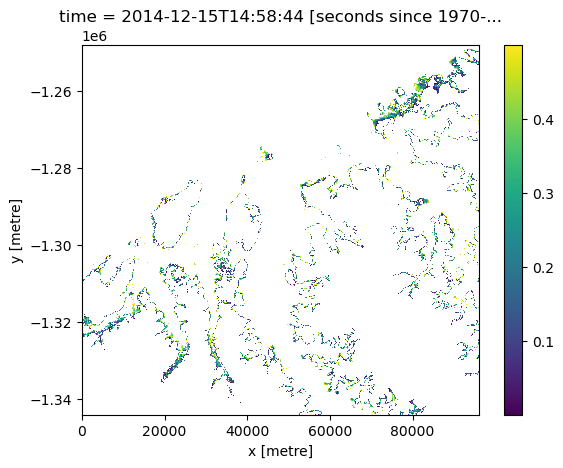

In [21]:
HAT_storm_10AHD_norm_05_0.plot()

In [22]:
# combine layers back together
supratidal_combine = ((HAT.fillna(0)) + (HAT_storm_norm_05_1.fillna(0)) + (HAT_storm_10AHD_norm_05_0.fillna(0))).squeeze('time')

# remove outside extent (make np.nan)
supratidal_elev_confidence_layer = xr.where(supratidal_mask == 1, supratidal_combine.values, np.nan)

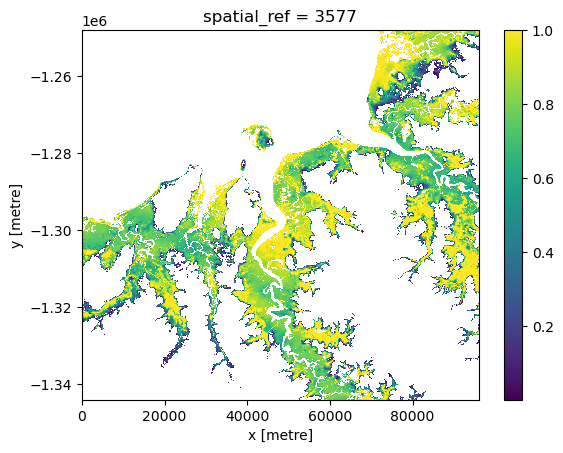

In [23]:
supratidal_elev_confidence_layer.plot()

### output to geotiff
- exports the supratidal_elev layer to see values of elevation
- exports the supratidal_elev_confidence_layer to see 0-1 score for based on HAT, HAT_SS and 0-10m AHD

In [24]:
# export
if export == False:
        pass
else:
    write_cog(geo_im=supratidal_elev,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_supratidal_elev_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)
    write_cog(geo_im=supratidal_elev_confidence_layer,
      fname=vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_supratidal_elev_confidence_' + time_range[0] + '.tif', # first part gets AOI name
      overwrite=True,
      nodata=0.0)